In [2]:
import torch as th
import numpy as np
import pickle
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from pytorch_lightning import seed_everything
import torch as th
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import sys
import glob
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '../../sample_scripts/')
# from sample_scripts.sample_utils.inference_utils import to_tensor
# from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

device = 'cuda:1'

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs, size=17):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(size, size))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def get_cfg(self):
    from config.base_config import parse_args
    cfg_file_path = glob.glob("/home/mint/guided-diffusion/config/*/*", recursive=True)
    cfg_file_path = [cfg_path for cfg_path in cfg_file_path if f"/{self.cfg_name}" in cfg_path]    # Add /{}/ to achieve a case-sensitive of folder
    print("[#] Config Path : ", cfg_file_path)
    assert len(cfg_file_path) <= 1
    assert len(cfg_file_path) > 0
    cfg_file = cfg_file_path[0]
    cfg = parse_args(ipynb={'mode':True, 'cfg':cfg_file})
    return cfg

In [3]:
ckpt_loader = ckpt_utils.CkptLoader(log_dir="Masked_Face_woclip+BgNoHead+shadow_256", cfg_name="Masked_Face_woclip+BgNoHead+shadow_256.yaml")
cfg = ckpt_loader.cfg
cfg.img_cond_model.in_image = cfg.img_cond_model.in_image + ['faceseg_bg_noface&nohair'] + ['faceseg_eyes']
cfg.img_cond_model.prep_image = [None, 'dilate=5', None]
cfg.img_model.image_size = 256
# Load dataset
cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
img_ext = '.jpg'
cfg.dataset.training_data = 'ffhq_256_with_anno'
cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/ffhq_256/'
cfg.dataset.deca_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/params/'
cfg.dataset.face_segment_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/face_segment/"
cfg.dataset.deca_rendered_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/rendered_images/"
cfg.dataset.laplacian_mask_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/eyes_segment/"
cfg.dataset.laplacian_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/laplacian/"

loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_='valid',
    cfg=cfg,
)

# _, _, avg_dict = load_data_img_deca(
#     data_dir=img_dataset_path,
#     deca_dir=deca_dataset_path,
#     batch_size=int(1e7),
#     image_size=cfg.img_model.image_size,
#     deterministic=cfg.train.deterministic,
#     augment_mode=cfg.img_model.augment_mode,
#     resize_mode=cfg.img_model.resize_mode,
#     in_image_UNet=cfg.img_model.in_image,
#     params_selector=cfg.param_model.params_selector + ['albedo'],
#     rmv_params=cfg.param_model.rmv_params,
#     set_='train',
#     cfg=cfg,
# )

[#] Model Path : 
#0 : /data/mint/model_logs_mount/ist-cluster-figure/Masked_Face_woclip+BgNoHead+shadow_256/
[#] Config Path :  ['/home/mint/Dev/DiFaReli/difareli-faster/config/Baseline/Masked_Face_woclip+BgNoHead+shadow_256.yaml']
Merging with :  Namespace(cfg='/home/mint/Dev/DiFaReli/difareli-faster/config/Baseline/Masked_Face_woclip+BgNoHead+shadow_256.yaml')



Loading deca params...: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb', 'shadow']
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip', 'faceseg_nohead', 'faceseg_bg_noface&nohair', 'faceseg_eyes']
DPM Image condition :  [None]


In [6]:
from importlib import reload
reload(params_utils)

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
f_mask2 = np.load('./FLAME_masks_face-id_tmp.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist() 
}        
for k in f_mask.keys():
    print(f_mask[k].shape, f_mask2[k].shape)
    print(np.all(f_mask[k] == f_mask2[k]))
# print(f_mask)
# print(v_mask)

(4512,) (4512,)
True
(1520,) (1520,)
True
(3264,) (3264,)
True
(3264,) (3264,)
True
(3522,) (3522,)
True
(1724,) (1724,)
True
(804,) (804,)
True
(1524,) (1524,)
True
(2272,) (2272,)
True
(2942,) (2942,)
True
(594,) (594,)
True
(10750,) (10750,)
True
(3522,) (3522,)
True
(1724,) (1724,)
True


In [11]:
from importlib import reload
reload(params_utils)

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist() 
}        

img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/valid/")
# img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60002.jpg'])
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg', '60000.jpg', '60001.jpg', '60002.jpg', '60004.jpg'])
dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1000,
                                    shuffle=False, num_workers=24)
                            
dat, model_kwargs = next(iter(subset_loader))
rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, 
                                                        idx=0, n=20, 
                                                        useTex=True, extractTex=True, 
                                                        deca_mode='', use_detail=True, mask=mask, repeat=False)

grid = torchvision.utils.make_grid(orig_visdict['shape_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid(orig_visdict['landmarks2d_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)                                            
grid = torchvision.utils.make_grid(orig_visdict['landmarks3d_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid(((orig_visdict['normal_images'] + 1) * 127.5).clamp_(0, 255).cpu())
show(grid/255)
grid = torchvision.utils.make_grid(orig_visdict['rendered_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid(orig_visdict['rendered_images_uv_texture'].mul(255).add_(0.5).clamp_(0, 255).cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid(model_kwargs['raw_image'].cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid((((model_kwargs['faceseg_bg_noface&nohair_img'] + 1) * 127.5)).float().cpu())
show(grid/255.0)
grid = torchvision.utils.make_grid((((model_kwargs['faceseg_eyes_img'] + 1) * 127.5)).float().cpu())
show(grid/255.0)


creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask


IndexError: list index out of range

(256, 256, 3)
(68, 2)


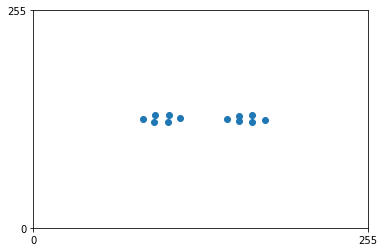

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Keypoints :  (68, 2)


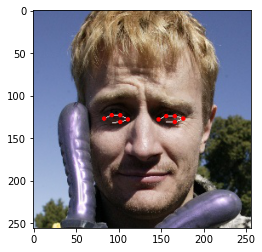

In [ ]:
lm = orig_visdict['landmarks2d'][0].cpu().numpy()
image = orig_visdict['inputs'][0].cpu().numpy()
image = np.transpose(image, (1, 2, 0))
print(image.shape)
lm[...,0] = lm[...,0]*image.shape[1]/2 + image.shape[1]/2
lm[...,1] = lm[...,1]*image.shape[0]/2 + image.shape[0]/2

print(lm.shape)
plt.scatter(x=lm[36:48, 0], y=lm[36:48, 1])
plt.xticks([0, 255])
plt.yticks([0, 255])
plt.show()

sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/decalib/utils/')
from sample_scripts.cond_utils.DECA.decalib.utils import util
reload(util)
plt.imshow(util.plot_kpts(image, lm, specific=list(range(36, 48))))
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


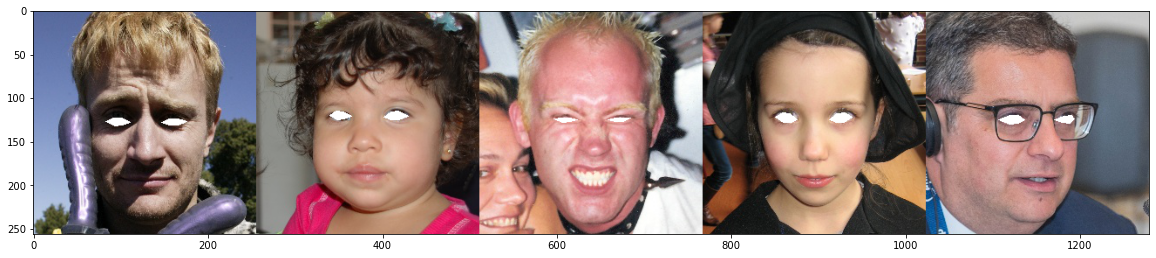

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


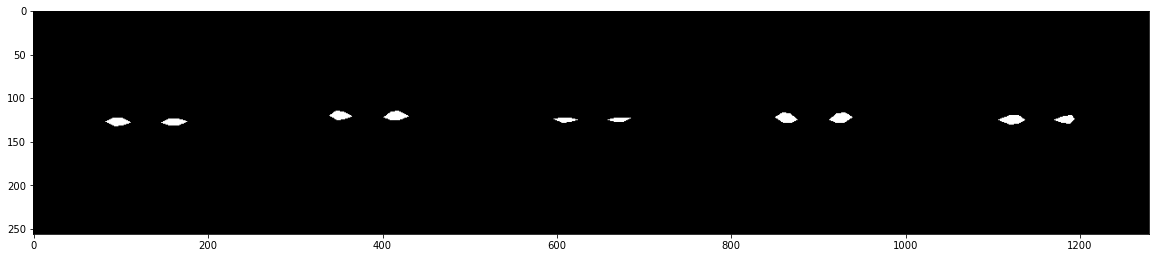

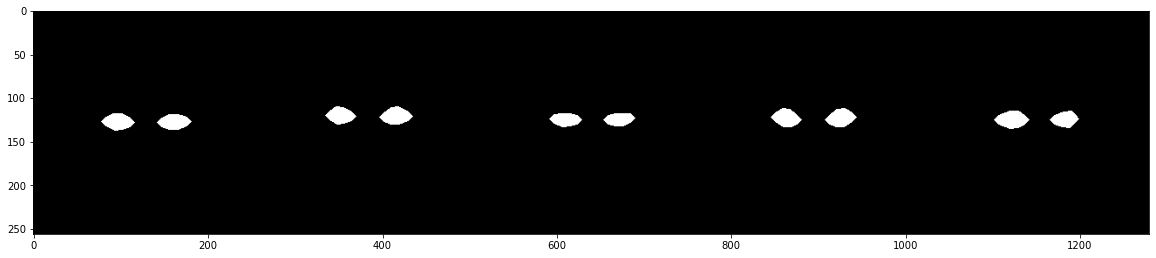

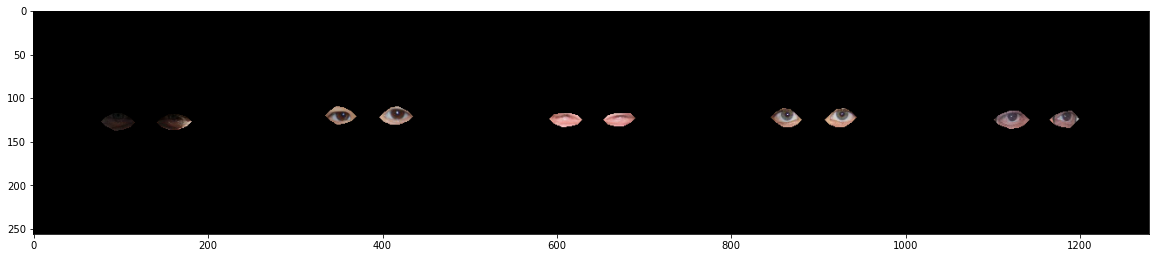

In [ ]:
import cv2
overlay = []
all_mask = []
all_image = []
for i in range(orig_visdict['inputs'].shape[0]):
    lm = orig_visdict['landmarks2d'][i].cpu().numpy()
    image = orig_visdict['inputs'][i].cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    all_image.append(image)
    lm[...,0] = lm[...,0]*image.shape[1]/2 + image.shape[1]/2
    lm[...,1] = lm[...,1]*image.shape[0]/2 + image.shape[0]/2
    drawing_set = [[36, 37, 38, 39], [36, 39, 40, 41], [42, 43, 44, 45], [42, 45, 46, 47]]
    image_mask = image.copy()
    mask = np.zeros_like(image_mask)
    for d in drawing_set:
        lm_tmp = lm[d, :].astype(np.int32)
        cv2.fillPoly(image_mask, pts = [lm_tmp], color =(255,255,255))
        cv2.fillPoly(mask, pts = [lm_tmp], color =(255,255,255))
    overlay.append(image_mask)
    all_mask.append(mask)
plt.figure(figsize=(20, 20))
plt.imshow(np.concatenate(overlay, axis=1))
plt.show()
plt.figure(figsize=(20, 20))
plt.imshow(np.concatenate(all_mask, axis=1))
plt.show()

import scipy 
all_expand_mask = []
for m in all_mask:
    expand_mask = scipy.ndimage.binary_dilation(m, iterations=5)
    expand_mask = expand_mask.astype(all_mask[0].dtype)
    all_expand_mask.append(expand_mask)
    
plt.figure(figsize=(20, 20))
plt.imshow(np.concatenate(all_expand_mask, 1))
plt.show()



masked_out = []
for i in range(orig_visdict['inputs'].shape[0]):
    image = orig_visdict['inputs'][i].cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    masked_out.append(all_expand_mask[i] * image)
    
plt.figure(figsize=(20, 20))
plt.imshow(np.concatenate(masked_out, 1))
plt.show()




(4, 2)


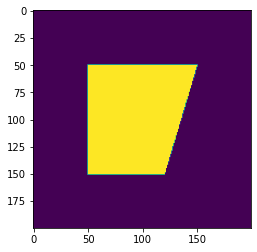

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
contours = np.array([[50,50], [50,150], [120,150], [150,50]])
print(contours.shape)
image = np.zeros((200,200))
cv2.fillPoly(image, pts = [contours], color =(255,255,255))
plt.imshow(image)
plt.show()

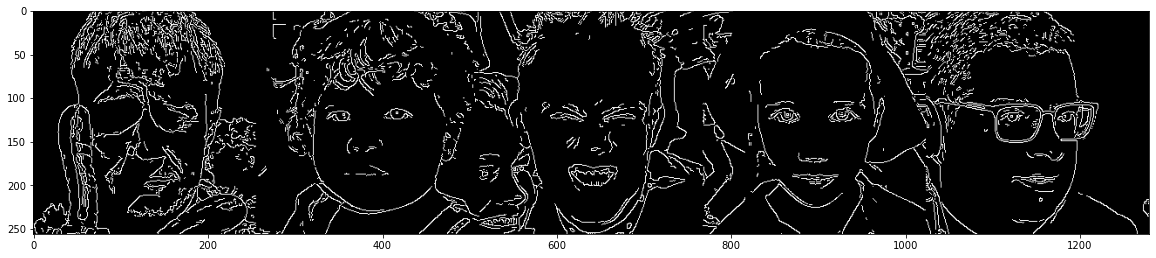

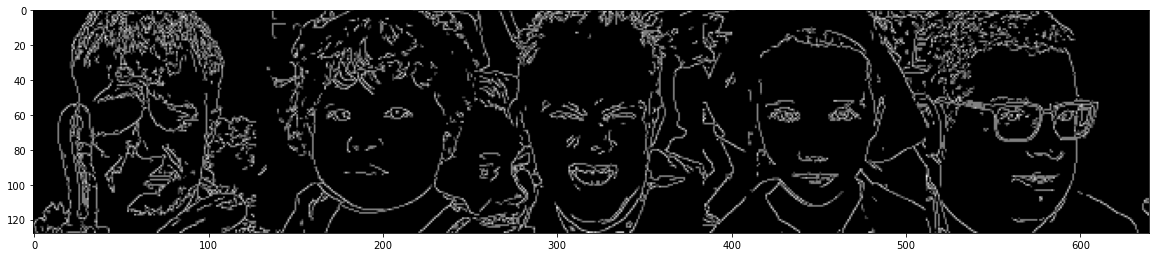

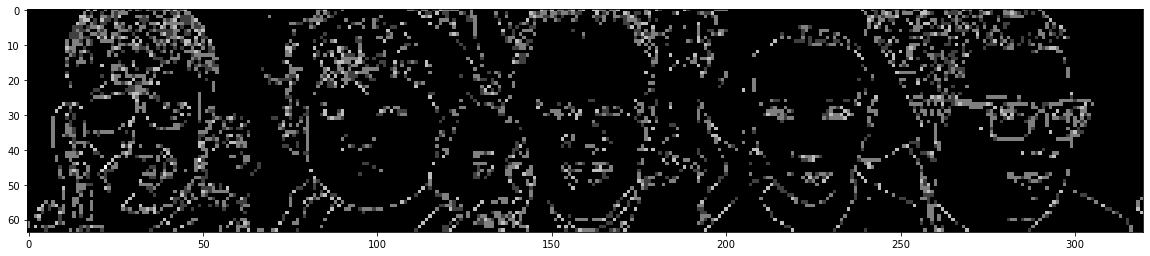

In [ ]:
# Canny
import cv2
e = []
for i in range(len(model_kwargs['raw_image'])):
    edges = cv2.Canny(np.transpose(model_kwargs['raw_image'][i].cpu().numpy().astype(np.uint8), (1, 2, 0)), 150, 200)
    e.append(edges)
plt.figure(figsize=(20, 20))
e = np.concatenate(e, 1)
plt.imshow(e, cmap='gray')
plt.show()

e = []
for i in range(len(model_kwargs['raw_image'])):
    edges = cv2.Canny(np.transpose(model_kwargs['raw_image'][i].cpu().numpy().astype(np.uint8), (1, 2, 0)), 150, 200)
    edges = cv2.resize(edges, (128, 128))
    e.append(edges)
plt.figure(figsize=(20, 20))
e = np.concatenate(e, 1)
plt.imshow(e, cmap='gray')
plt.show()

e = []
for i in range(len(model_kwargs['raw_image'])):
    edges = cv2.Canny(np.transpose(model_kwargs['raw_image'][i].cpu().numpy().astype(np.uint8), (1, 2, 0)), 150, 200)
    edges = cv2.resize(edges, (64, 64))
    e.append(edges)
plt.figure(figsize=(20, 20))
e = np.concatenate(e, 1)
plt.imshow(e, cmap='gray')
plt.show()

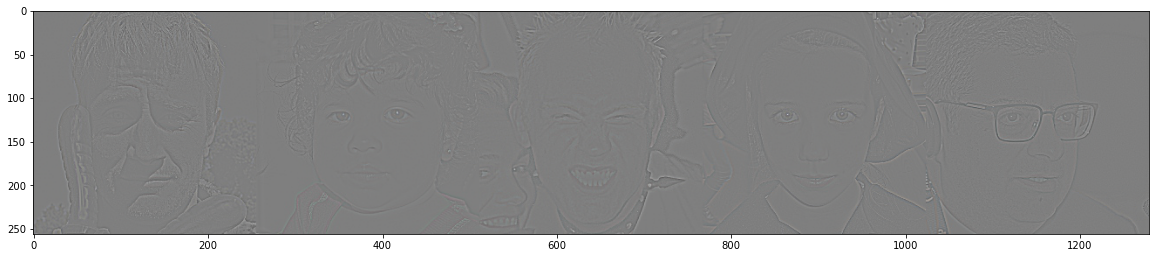

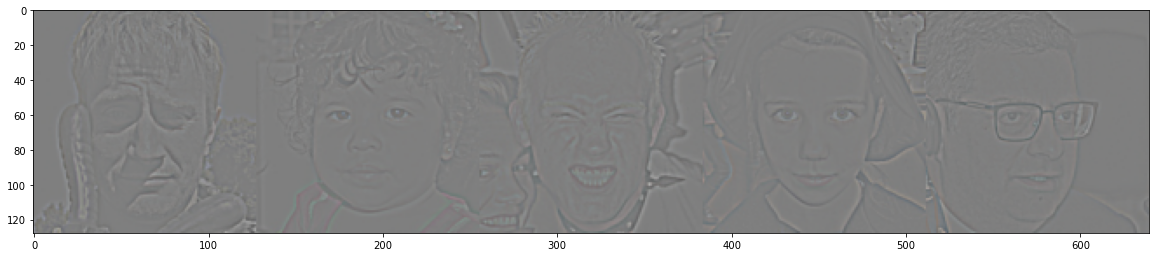

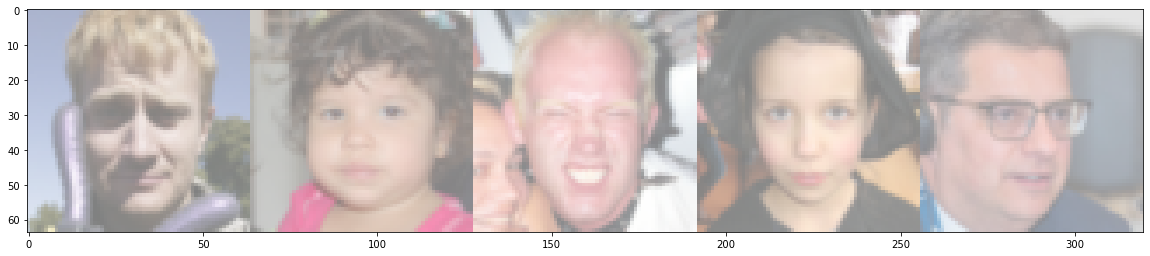

In [ ]:
import cv2
import numpy as np
import imageio, pickle, ssl, time
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
from IPython.display import Image

def create_gaussian_pyramid(img, level=5):
  pys = [img]
  for i in range(level-1):
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)), interpolation=cv2.INTER_AREA)
    pys.append(img)
  return pys

def create_laplacian_pyramid(img, level=5):
  pys = create_gaussian_pyramid(img, level)
  for i in range(level-1):
    pys[i] = pys[i] - cv2.resize(pys[i+1], (pys[i].shape[1], pys[i].shape[0]))
  return pys


lap = []
n_lap = 3
for i in range(len(model_kwargs['raw_image'])):
    im = np.transpose(model_kwargs['raw_image'][i].cpu().numpy(), (1, 2, 0))
    im = (im / 255.0)
    edges = create_laplacian_pyramid(im, n_lap)
    lap.append(edges)


lap_img = []
for i in range(n_lap):
    tmp = []
    for j in range(len(model_kwargs['raw_image'])):
        tmp.append(lap[j][i])
    tmp = np.concatenate(tmp, 1)
    lap_img.append(tmp)

for i in range(n_lap):
    plt.figure(figsize=(20, 20))
    plt.imshow(((lap_img[i] + 1)*127.5).astype(np.uint8))
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


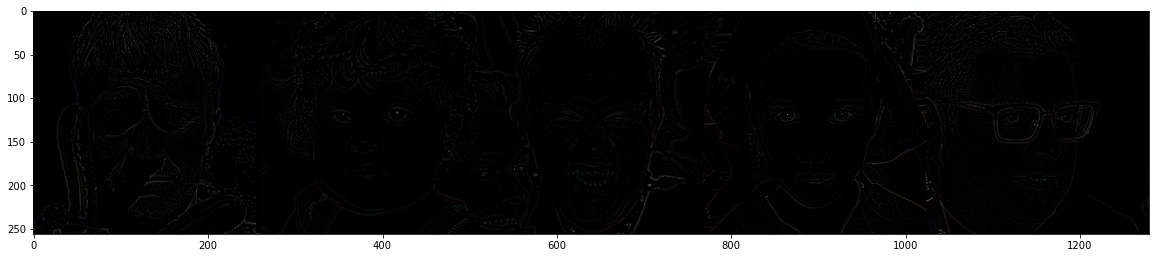

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


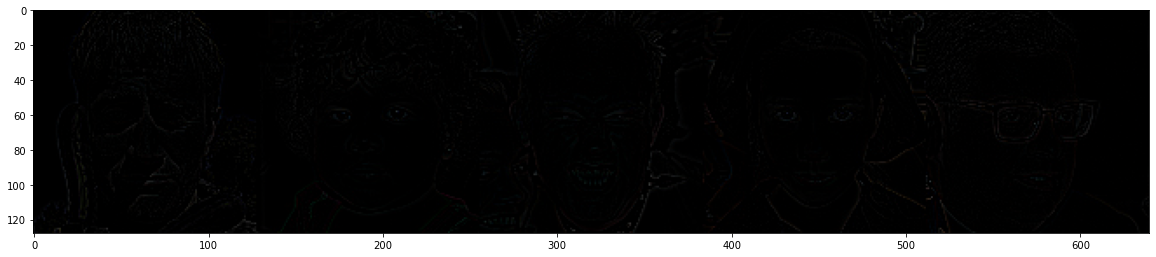

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


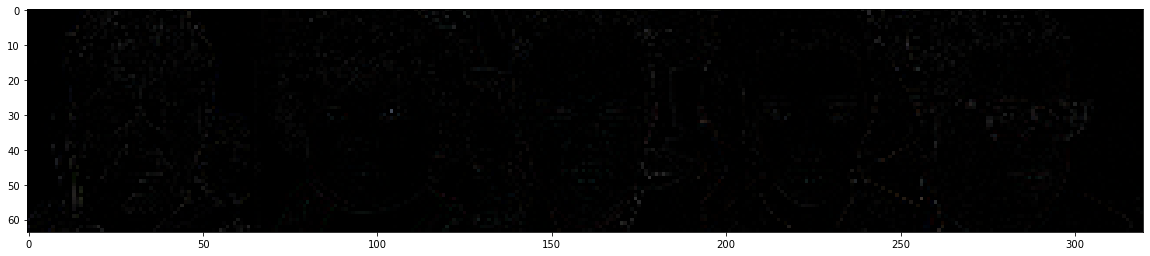

In [ ]:
res_mult = [1, 2, 4]
out = {}
for r in res_mult:
  out[r] = []
  for j in range(len(model_kwargs['raw_image'])):
    res = 256 // r
    lap_res = cv2.resize(lap[j][0], (res, res), cv2.INTER_AREA)
    out[r].append(lap_res)
  out[r] = np.concatenate(out[r], 1)
  
  
for r in res_mult:
  plt.figure(figsize=(20, 20))
  plt.imshow(((out[r] + 1)*127.5).astype(np.uint8))
  plt.imshow(out[r])
  plt.show()

creating the FLAME Decoder
[#] DECA : SRenderY applied mask
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar


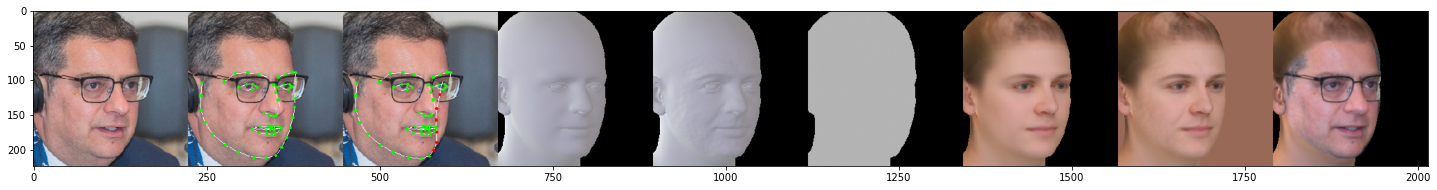

creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask


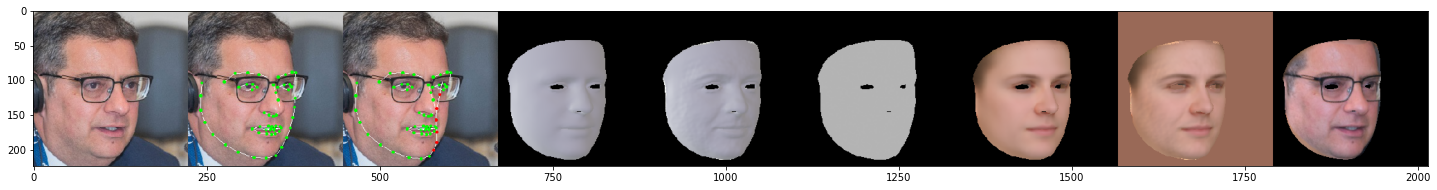

In [ ]:
from importlib import reload
sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
deca_cfg.model.extract_tex = True
deca_cfg.rasterizer_type = 'standard'
deca_cfg.model.use_tex = False
deca = DECA(config = deca_cfg, device='cuda', mode='only_renderer', mask=mask)
reload(params_utils)

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist()
}

img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60004.jpg'])
dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1000,
                                    shuffle=False, num_workers=24)
                            
dat, model_kwargs = next(iter(subset_loader))
rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=20, useTex=True, extractTex=True, deca_mode='', use_detail=True, mask=None, repeat=False)
plt.figure(figsize=(25, 25))
plt.imshow(deca.visualize(orig_visdict)[..., ::-1])
plt.show()

rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=20, useTex=True, extractTex=True, deca_mode='', use_detail=True, mask=mask, repeat=False)
plt.figure(figsize=(25, 25))
plt.imshow(deca.visualize(orig_visdict)[..., ::-1])
plt.show()

In [ ]:
from importlib import reload
reload(params_utils)
import tqdm

def gen_masked_face3d(batch_size, mask, set_, path):
    img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{set_}/")
    avail_img_name = [i.split('/')[-1] for i in img_path]
    img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=avail_img_name)
    dat = th.utils.data.Subset(dataset, indices=img_idx)
    subset_loader = th.utils.data.DataLoader(dat, batch_size=batch_size,
                                        shuffle=False, num_workers=24, drop_last=False)
    
    sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/')
    from decalib.deca import DECA
    from decalib.datasets import datasets 
    from decalib.utils import util
    from decalib.utils.config import cfg as deca_cfg
    deca_cfg.model.extract_tex = True
    deca_cfg.rasterizer_type = 'standard'
    deca_cfg.model.use_tex = False
    deca = DECA(config = deca_cfg, device='cuda', mode='only_renderer', mask=mask)
    
    clip_path = f"{path}_wclip/{set_}"
    woclip_path = f"{path}_woclip/{set_}"
    os.makedirs(clip_path, exist_ok=True)
    os.makedirs(woclip_path, exist_ok=True)
    for batch_ndx, sample in tqdm.tqdm(enumerate(subset_loader)):
        dat, model_kwargs = sample
    
        _, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=batch_size, mask=mask, repeat=False, deca_obj=deca)
        # grid = torchvision.utils.make_grid(orig_visdict['shape_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
        # show(grid/255.0)
        
        rendered_image = orig_visdict['shape_images']
        rendered_image = rendered_image.permute((0, 2, 3, 1))   # BxHxWxC
        for i in range(rendered_image.shape[0]):
            name = model_kwargs['image_name'][i].split('.')[0]
            # np.save(file=f"{woclip_path}/{name}.npy", arr=rendered_image[i].cpu().numpy())
            torchvision.utils.save_image(tensor=rendered_image[i].permute((2, 0, 1)).cpu(), fp=f"{clip_path}/{name}.png")
            
        _, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=batch_size, mask=None, repeat=False, deca_obj=None)
        rendered_image = orig_visdict['shape_images']
        rendered_image = rendered_image.permute((0, 2, 3, 1))   # BxHxWxC
        for i in range(rendered_image.shape[0]):
            name = model_kwargs['image_name'][i].split('.')[0]
            torchvision.utils.save_image(tensor=rendered_image[i].permute((2, 0, 1)).cpu(), fp=f"{clip_path}/{name}_full.png")
        break
f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')

print(f_mask.keys())
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist() + f_mask['boundary'].tolist() + f_mask['neck'].tolist() + f_mask['scalp'].tolist(),
    # 'f_mask':sum([f_mask[k].tolist() for k in f_mask.keys()], [])
}
gen_masked_face3d(1, mask, set_="valid", path="/data/mint/DPM_Dataset/ffhq_256_with_anno/rendered_images/deca_masked_face_images")

dict_keys(['eye_region', 'neck', 'left_eyeball', 'right_eyeball', 'right_ear', 'right_eye_region', 'forehead', 'lips', 'nose', 'scalp', 'boundary', 'face', 'left_ear', 'left_eye_region'])
creating the FLAME Decoder
[#] DECA : SRenderY applied mask


0it [00:00, ?it/s]

creating the FLAME Decoder


0it [00:16, ?it/s]


In [ ]:
from importlib import reload
reload(params_utils)
import tqdm

def gen_masked_face3d(batch_size, mask, set_, path):
    img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{set_}/")
    avail_img_name = [i.split('/')[-1] for i in img_path]
    img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=avail_img_name)
    dat = th.utils.data.Subset(dataset, indices=img_idx)
    subset_loader = th.utils.data.DataLoader(dat, batch_size=batch_size,
                                        shuffle=False, num_workers=24, drop_last=False)
    
    sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/')
    from decalib.deca import DECA
    from decalib.datasets import datasets 
    from decalib.utils import util
    from decalib.utils.config import cfg as deca_cfg
    deca_cfg.model.extract_tex = True
    deca_cfg.rasterizer_type = 'standard'
    deca_cfg.model.use_tex = False
    deca = DECA(config = deca_cfg, device='cuda', mode='only_renderer', mask=mask)
    
    clip_path = f"{path}_wclip/{set_}"
    woclip_path = f"{path}_woclip/{set_}"
    os.makedirs(clip_path, exist_ok=True)
    os.makedirs(woclip_path, exist_ok=True)
    for batch_ndx, sample in tqdm.tqdm(enumerate(subset_loader)):
        dat, model_kwargs = sample
    
        _, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, idx=0, n=batch_size, mask=mask, repeat=False, deca_obj=deca)
        # grid = torchvision.utils.make_grid(orig_visdict['shape_images'].mul(255).add_(0.5).clamp_(0, 255).cpu())
        # show(grid/255.0)
        
        rendered_image = orig_visdict['shape_images']
        rendered_image = rendered_image.permute((0, 2, 3, 1))   # BxHxWxC
        for i in range(rendered_image.shape[0]):
            name = model_kwargs['image_name'][i].split('.')[0]
            # np.save(file=f"{woclip_path}/{name}.npy", arr=rendered_image[i].cpu().numpy())
            torchvision.utils.save_image(tensor=rendered_image[i].permute((2, 0, 1)).cpu(), fp=f"{clip_path}/{name}.png")
       
f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')

print(f_mask.keys())
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist() + f_mask['boundary'].tolist() + f_mask['neck'].tolist() + f_mask['scalp'].tolist(),
    # 'f_mask':sum([f_mask[k].tolist() for k in f_mask.keys()], [])
}
gen_masked_face3d(1, mask, set_="valid", path="/data/mint/DPM_Dataset/ffhq_256_with_anno/rendered_images/deca_masked_face_images")

dict_keys(['eye_region', 'neck', 'left_eyeball', 'right_eyeball', 'right_ear', 'right_eye_region', 'forehead', 'lips', 'nose', 'scalp', 'boundary', 'face', 'left_ear', 'left_eye_region'])
creating the FLAME Decoder
[#] DECA : SRenderY applied mask


556it [08:16,  1.10s/it]

In [ ]:
print(model_kwargs.keys())
import cv2
edges = cv2.Canny(np.transpose(model_kwargs['raw_image'][0].cpu().numpy().astype(np.uint8), (1, 2, 0)), 190, 200)
plt.imshow(edges, cmap='gray')
plt.show()

# Create the masking faces indices 

In [ ]:
assert False    # Remove this line
from model_3d.FLAME.config import cfg as flame_cfg
import model_3d.FLAME.FLAME as FLAME
import model_3d.FLAME.utils.renderer as renderer_lib
import model_3d.FLAME.utils.util as util
from importlib import reload
import numpy as np
reload(renderer_lib)
reload(FLAME)

flame = FLAME.FLAME(flame_cfg.model).cuda()
renderer = renderer_lib.SRenderY(image_size=256, obj_filename=flame_cfg.model.topology_path, uv_size=flame_cfg.model.uv_size).cuda()
print(renderer.faces.shape)
print(renderer.face_colors.shape)


def index_masking_faces(mask, faces):
    print("[#] Create indexing masked of faces...")
    import tqdm, pickle
    rm_faces = {}
    for k in mask.keys():
        rm_faces[k] = []
        print("Processing : ", k)
        for m in tqdm.tqdm(mask[k].tolist()):
            for i, f in enumerate(faces[0]):
                if m in f:
                    rm_faces[k].append(i)
        rm_faces[k] = np.array(rm_faces[k])
    
    with open('FLAME_masks_face-id.pkl', 'wb') as output:
        pickle.dump(rm_faces, output)

mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
count = 0
mask_list = []
for k, v in mask.items():
    count += len(v)
    print(f"{k} - {v.shape}")
    mask_list.append(v)
mask_list = np.concatenate(mask_list, -1)

print(renderer.faces.shape)
print(type(mask['face'][0]))
print("#"*50)
index_masking_faces(mask, renderer.faces)